<a href="https://colab.research.google.com/github/Edwin10151/MachineLearning/blob/main/JunkClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## JunkFood Classification
Identify whether the food is junk food or healthy food in the form of image

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import io
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
from random import shuffle
from sklearn.model_selection import train_test_split
from IPython.display import display, Image
from google.colab import drive


In [4]:
!pip install zipfile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [5]:
print(tf.__version__)
print(hub.__version__)

2.5.0
0.12.0


In [ ]:
# Unzip JunkFood Zip File
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood2.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood3.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood4.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
# Unzip Healthy Food Zip File
!unzip 'drive/MyDrive/JunkFoodClassification/healthyfood.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'
!unzip 'drive/MyDrive/JunkFoodClassification/healthyfood2.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'
!unzip 'drive/MyDrive/JunkFoodClassification/healthy3.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'

Archive:  drive/MyDrive/JunkFoodClassification/junkfood.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731654015.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/junkfood2.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732443379.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/junkfood3.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627734091490.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/junkfood4.zip
replace drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627737603584.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  drive/MyDrive/JunkFoodClassification/healthyfood.zip
Archive:  drive/MyDrive/JunkFoodClassification/healthyfood2.zip
replace drive/MyDrive/JunkFoodClassification/HealthyFood/HelloIMG1627734467495.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip 'drive/MyDrive/JunkFoodClassification/junkfood5.zip' -d 'drive/MyDrive/JunkFoodClassification/JunkFood'
!unzip 'drive/MyDrive/JunkFoodClassification/healthyfood4.zip' -d 'drive/MyDrive/JunkFoodClassification/HealthyFood'

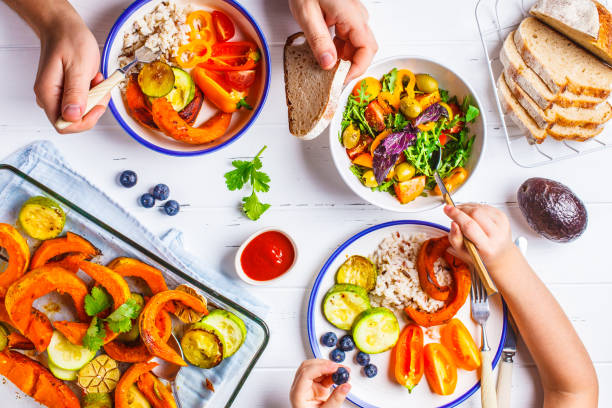

In [5]:
#View an image 
Image('drive/MyDrive/JunkFoodClassification/HealthyFood/HelloIMG1627738279448.jpeg')

##Preprocessing Images(turning images into Tensors)
To preprocess our images into Tensor we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpeg) into Tensors
4. Normalize our image(convert color channel values from 0-255 to 0-1)
5. Resize the iamge to be a shape of (224,224)
6. Return the modified image

In [141]:
JunkFoodList = ["drive/MyDrive/JunkFoodClassification/JunkFood/" + images for images in tqdm(os.listdir("drive/MyDrive/JunkFoodClassification/JunkFood"))]
HealthyFoodList = ["drive/MyDrive/JunkFoodClassification/HealthyFood/" + images for images in tqdm(os.listdir("drive/MyDrive/JunkFoodClassification/HealthyFood"))]
JunkFoodList[:10]


100%|██████████| 182/182 [00:00<00:00, 574821.78it/s]

100%|██████████| 185/185 [00:00<00:00, 998643.81it/s]


['drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731654015.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731658360.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731661722.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731776927.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627731976131.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732072863.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732092209.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732098646.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732102286.jpeg',
 'drive/MyDrive/JunkFoodClassification/JunkFood/HelloIMG1627732119294.jpeg']

In [142]:
print(len(JunkFoodList))
print(len(HealthyFoodList))

182
185


In [163]:
#First, we define image size
IMG_SIZE = 224

#Define category of Junk & Healthy
image_list = [JunkFoodList, HealthyFoodList]
new_list = []
def process_image(img_size = IMG_SIZE):
    for each_list in image_list:
      category_index = image_list.index(each_list)

      for images in tqdm(each_list):
        image = tf.io.read_file(images)
        image = tf.io.decode_image(image, channels = 3) # RGB
        image = tf.image.convert_image_dtype(image,tf.float32)
        image = tf.image.resize(image, size =[IMG_SIZE, IMG_SIZE])
        new_list.append([image, category_index])

process_image()
# process_image(JunkFoodList, JunkFood, JunkFood)
# process_image(HealthyFoodList, HealthyFood, HealthyFood)


100%|██████████| 182/182 [00:02<00:00, 66.57it/s]

100%|██████████| 185/185 [00:02<00:00, 72.94it/s]


In [164]:
print(len(new_list))

367


In [169]:
X = []
y = []
for image_set, category in new_list:
  X.append(image_set)
  y.append(category)
print(X[:1], y[:1])

[<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6191677 , 0.9590037 , 0.9732694 ],
        [0.67178875, 0.9728092 , 0.9915767 ],
        [0.6033214 , 0.93581444, 0.9606043 ],
        ...,
        [0.69857967, 0.96048415, 0.98401356],
        [0.72843057, 0.95924294, 0.9682065 ],
        [0.6542621 , 0.9539818 , 0.96364576]],

       [[0.64659864, 0.9413366 , 0.9601041 ],
        [0.66718686, 0.9445979 , 0.9521809 ],
        [0.63539416, 0.9406963 , 0.9559624 ],
        ...,
        [0.7020208 , 0.97332966, 0.99257725],
        [0.6829326 , 0.97088784, 0.9675265 ],
        [0.6887155 , 0.96022415, 0.97937185]],

       [[0.6847339 , 0.9580833 , 0.98205286],
        [0.66604644, 0.93271315, 0.9366347 ],
        [0.6636055 , 0.934754  , 0.9442778 ],
        ...,
        [0.66794634, 0.943597  , 0.95119995],
        [0.64783925, 0.96470594, 0.9686275 ],
        [0.6932573 , 0.9613247 , 0.97238904]],

       ...,

       [[0.47104797, 0.89341706, 0.9172863 ],
        [0.4

In [170]:
NUM_IMAGES = 110#@param{type:"slider", min:100,max :1000, step:100}

In [172]:
# Split the images into training and validation of total size NUM_IMAGES
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.35, random_state = 42)

In [179]:
def show_25_images(images, label_set):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(label_set[i])
    # Turn gird lines off
    plt.axis("off")

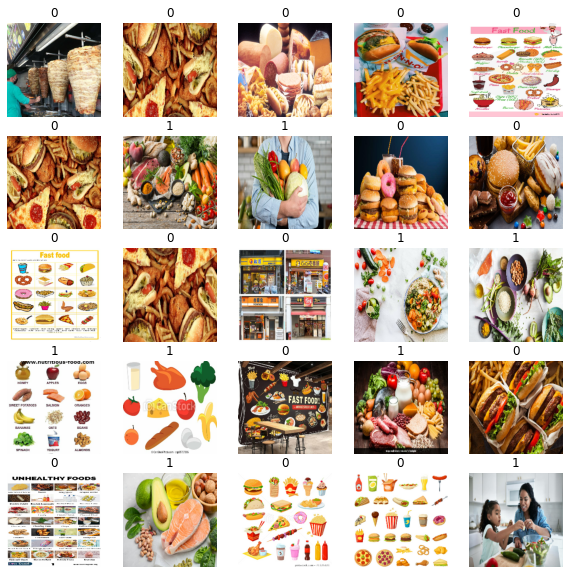

In [180]:
show_25_images(X_train, y_train)